# What drives the price of a car?



****OVERVIEW****

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Determine Business Objectives

The information provided lists a series of used-car transactions across the U.S. It is raw data and has not been filtered or edited for accuracy.

The goal of this exercise is to provide used-car dealerships with an understanding of the factors that influence a vehicle's value (both positively and negatively). This will enable used-car dealers to maintain an inventory of cars, thereby allowing greater profit.



In [199]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import category_encoders as TargetEncoder
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset, explore what it contains, and how it could be used to inform your business understanding.

#### Collect and Describe Initial Data

The dataset for this modeling was provided. The Vehicles.csv file includes 426k records. The Vehicles dataset consists of 18 attributes/features with 426880 records.


In [200]:
# Describing the data that has been provided using Pandas functions
# Save to df
data=pd.read_csv('data/vehicles.csv')

# Shape and preview
print('Vehicles  Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()


Vehicles  Shape : (426880, 18)


id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [201]:
# Use a Dataframe describe/view some basic statistical details like percentile, mean, std etc. of the dataset
data.describe()

id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07

#### Explore the Data

Exploring the data further, lets describe the dataframe to get a list of provided attributes/features.

In [202]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Determine the percentage of Columns that are null in relation to the total number of columns


In [203]:

for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(data[column].isnull().sum() /
                                               data[column].shape[0]))

year : 0.28%
manufacturer : 4.13%
model : 1.24%
condition : 40.79%
cylinders : 41.62%
fuel : 0.71%
odometer : 1.03%
title_status : 1.93%
transmission : 0.60%
VIN : 37.73%
drive : 30.59%
size : 71.77%
type : 21.75%
paint_color : 30.50%


#### Determine the number of null columns

In [204]:
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [205]:
# Dollar formatter for prices

def dollar_formatter(x, pos):
    return f'${x:,.0f}'

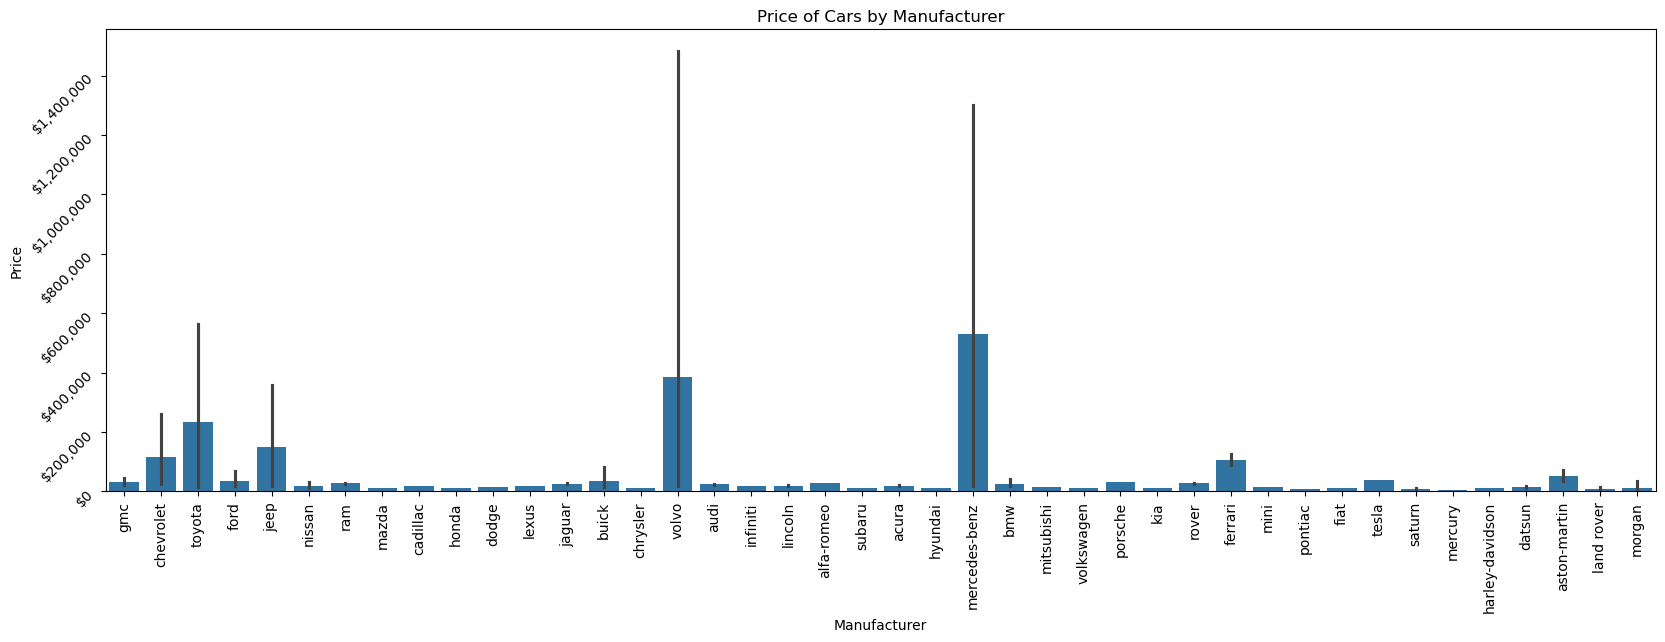

In [206]:
# To further explore the data, let's visualize some of the data and potentially visualize the relationship to price

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='manufacturer', y='price', data=data)
plt.yticks(rotation=45)
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.show()

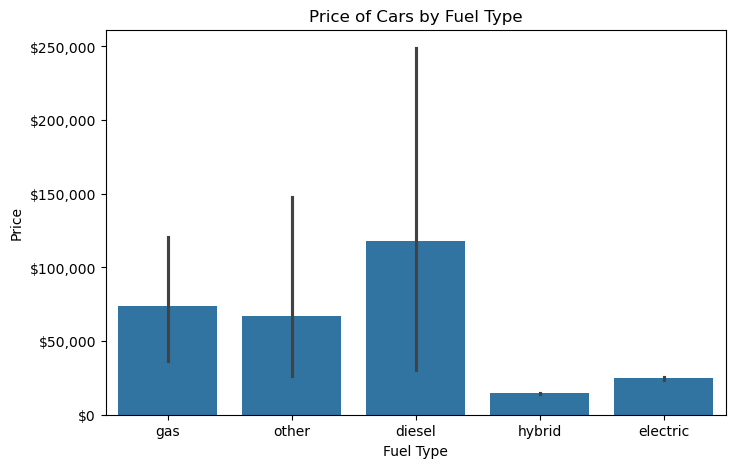

In [207]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='fuel', y='price', data=data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price")
plt.show()

#Vehicle prices over $100,000 are unreasonable and will be considered errors in the data gathering process.

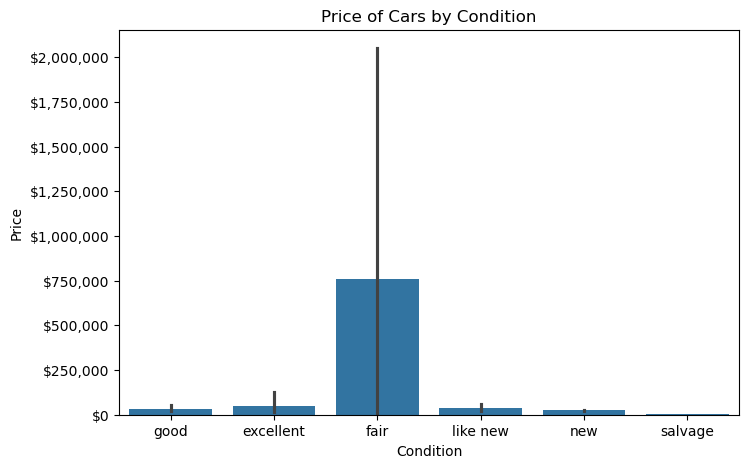

In [208]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='condition', y='price', data=data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Condition")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.show()

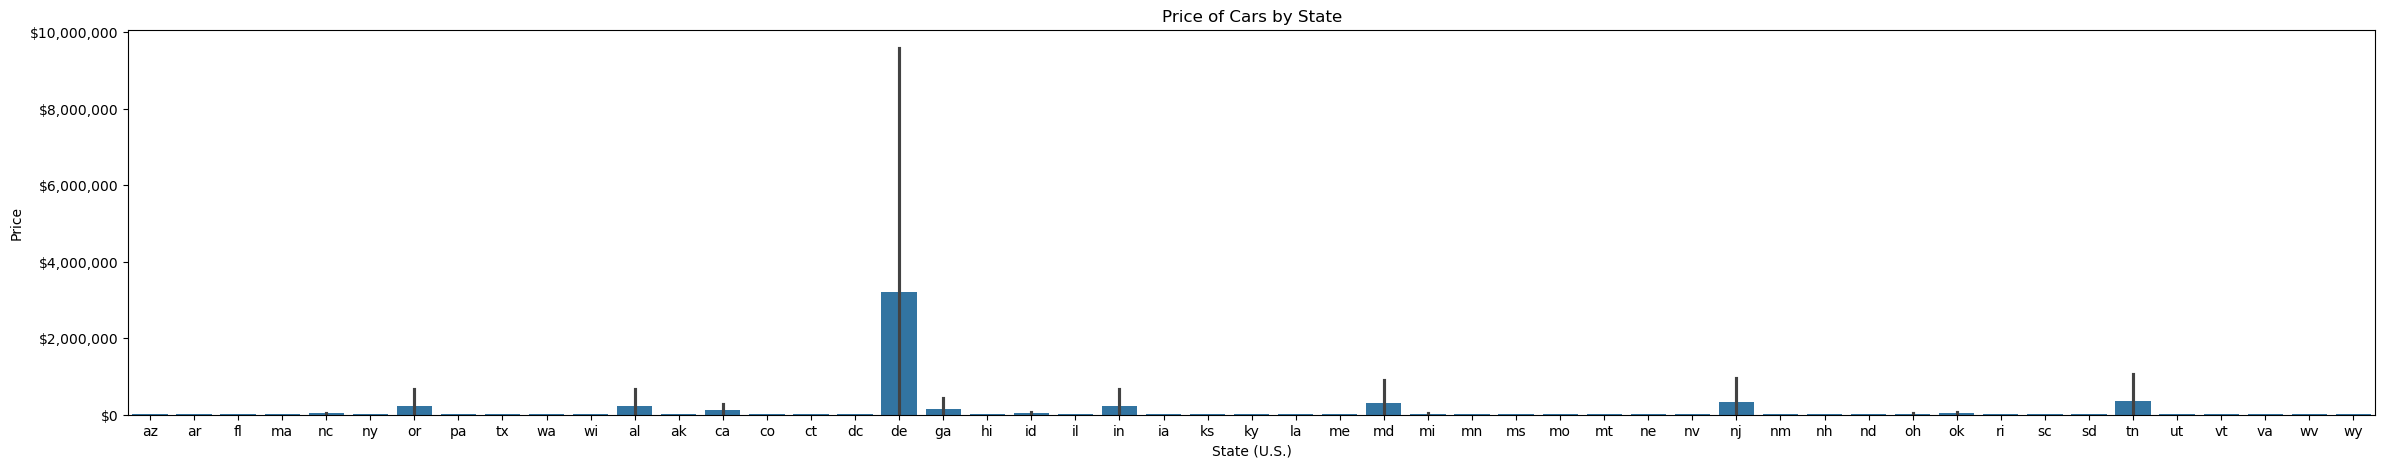

In [209]:
fig, ax = plt.subplots(figsize=(29,5))
sns.barplot(x='state', y='price', data=data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by State")
plt.xlabel("State (U.S.)")
plt.ylabel("Price")
plt.show()

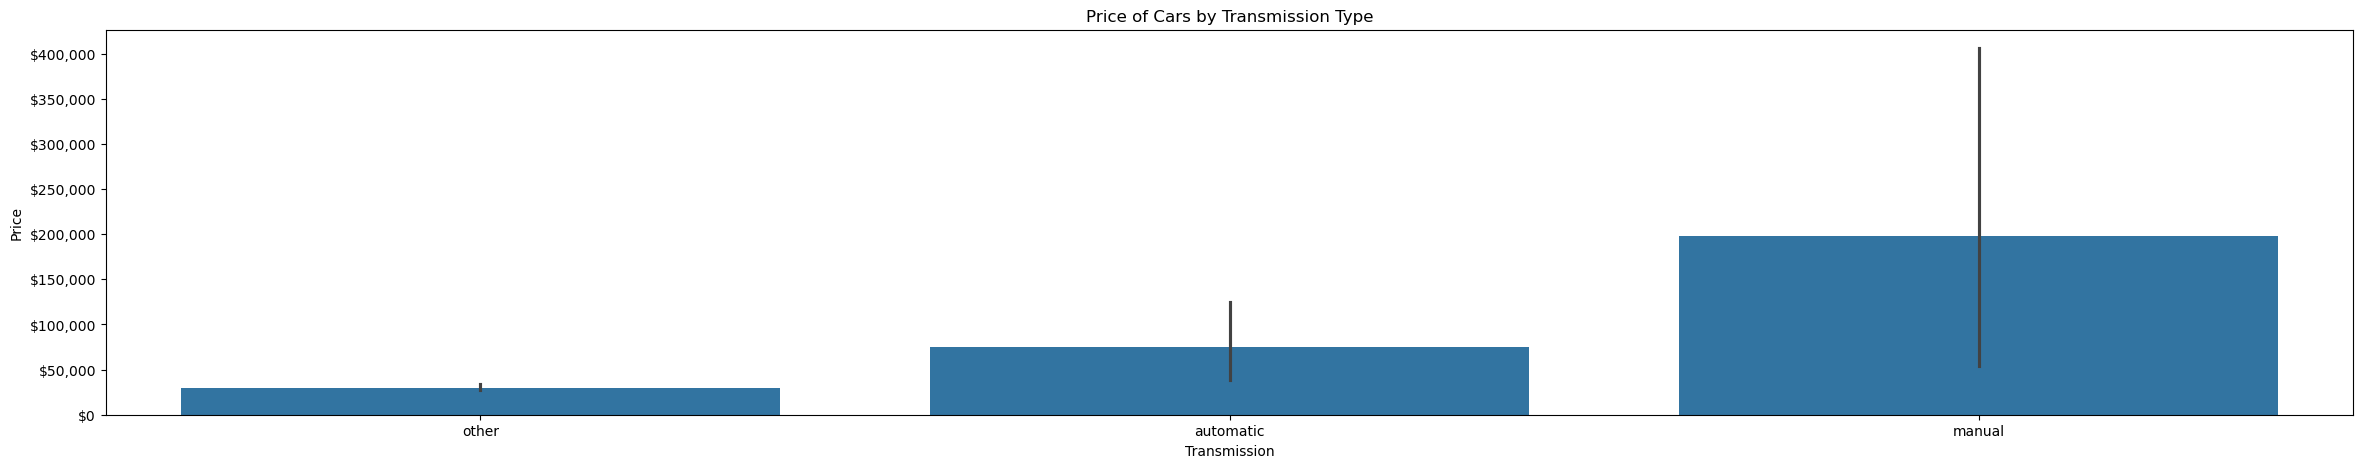

In [210]:
fig, ax = plt.subplots(figsize=(29,5))
sns.barplot(x='transmission', y='price', data=data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Transmission Type")
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.show()

In [211]:
# Select categorical columns (object or category dtype)
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column and print unique values + counts
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {data[col].nunique()}")
    print(f"Unique values: {data[col].unique()[:20]}")  # show first 20 unique values for readability


Column: region
Number of unique values: 404
Unique values: ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery']

Column: manufacturer
Number of unique values: 42
Unique values: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln']

Column: model
Number of unique values: 29649
Unique values: [nan 'sierra 1500 crew cab slt' 'silverado 1500' 'silverado 1500 crew'
 'tundra double cab sr' 'f-150 xlt' 'sierra 2500 hd extended cab'
 'silverado 1500 double' 'tacoma' 'colorado extended cab'
 'corvette grand sport' 'cherokee' 'wrangler unlimited sport'
 'silverado 1500 regular' 'colorado crew cab z71'
 'tacoma access cab pickup' '

Correlation Matrix:
                id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000


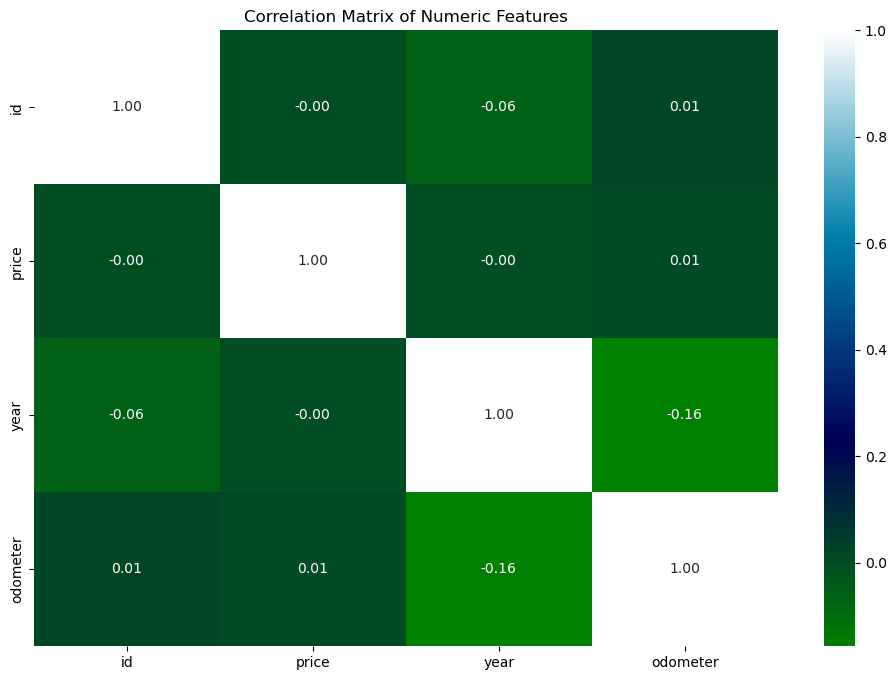

year       -0.059040
odometer    0.010721
price      -0.002779
Name: id, dtype: float64


In [212]:

correlation_matrix = data.corr(numeric_only=True)

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap for better visualization
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="ocean", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Extract correlations with 'price'
price_corr = correlation_matrix['price'].drop('price')  # drop self-correlation

price_corr = correlation_matrix['id'].drop('id') 

# Sort correlations by absolute value (strongest relationships first)
top_corr = price_corr.abs().sort_values(ascending=False)

# Display top correlations
print(price_corr.loc[top_corr.index].head(10))

#### Columns - Identification and action to be performed based on information gathered so far and understanding of the industry:

**id:**

This is a unique value assigned by the data store.
**Action:** Delete this column as we can't use it in regression


**region:**

Name of the region where the transaction was reported. 0% of missed records
**Action:** None


**price:**

Sales price for the car. 7.7% of the records have a value of 0.
**Action:** Remove records with zero values, as they are necessary for predictions. **Remove** all rows with a price over $100,000, as this is an anomaly in the data-gathering process.


**year:**

Year of the car. 0.3% missed records
**Action:** Filling with the most common value - records before 1948 to be removed. It is not plausible to have a used car that old still in sellable condition via a dealer.


**manufacturer:**

Name of the manufacturer. 4.1% of records missed
**Action:** Filling with "Other" as this is a categorical column


**model:**

Name of the model for the car sold. 1.2% of records missed
**Action:** Filling with "Other" as this is a categorical column


**condition:**

The car's condition when sold. Missed records 40.8%
**Action:** Filling with the most common value


**cylinders:**

Missed record 41.6 %
**Action:** Remove the word cylinders, replace others and missed values by filling with the most common value. Remove any record with fewer than four cylinders.


**fuel:**

Missed records 0.7%
**Action:** Filling with "Other" as this is a categorical column


**odometer:**

Odometer when the vehicle is sold. 1% missed
**Action:** Filling with the odometer mean value


**title_status:**

This represents the car's title status. 1.9%
**Action:** Filling with the most common value


**transmission:**

Missed records 0.6 %
**Action:** Filling with "Other" as this is a categorical column


**VIN:**

Must be a unique value by car. Missed 37.7%
**Action:** Remove column as we can't use it in regressions.


**drive:**

Missed records 30.6%
**Action:** Remove column as we can't use it in regressions.


**size:**

Classification for the size of the vehicle. 71.8% of records are missing.
**Action:** Remove column as we can't use it in regressions


**type:**

Missed records 21.8%
**Action:** Filling with "Other" as this is a categorical column

**paint_color:**

Missed records 30.5%
**Action:** Remove column as we can't use it in regressions.


**state:**

State within the U.S. where the vehicle transaction occurred
**Action:** Remove


**region:**

Region within the State where the transaction occurred
**Action:** Remove

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [343]:
# Drop the 'id' column
data_clean = data.drop(columns=['id'])

# VIN is a unique value and will be removed
data_clean = data_clean.drop(columns=['VIN', 'size', 'drive', 'paint_color', 'state', 'region'])

# Drop rows with missing values
# data_clean = data_clean.dropna()

# remove all rows where price = 0
data_clean = data_clean[data_clean['price'] > 0]

# Remove extreme auto prices
data_clean = data_clean[(data_clean['price'] >= 100) & (data_clean['price'] <= 100000)]

# Filling criteria:
data_clean["year"] = data_clean["year"].fillna(data_clean["year"].mode()[0])
data_clean['year'] = data_clean['year'].apply(lambda x: int(x))
data_clean["manufacturer"] = data_clean["manufacturer"].fillna('other')
data_clean["model"] = data_clean["model"].fillna('other')
data_clean["condition"] = data_clean["condition"].fillna(data_clean["condition"].mode()[0])
data_clean["cylinders"] = data_clean['cylinders'].str.replace(' cylinders', '')
data_clean["cylinders"] = data_clean["cylinders"].fillna(data_clean["cylinders"].mode()[0])
data_clean["cylinders"] = data_clean['cylinders'].str.replace('other', data_clean["cylinders"].mode()[0])
data_clean["cylinders"] = pd.to_numeric(data_clean['cylinders'])

# Removing any Cylinder readings less than 4
data_clean = data_clean.query('cylinders >= 4')  
data_clean["odometer"] = data_clean["odometer"].fillna(data_clean["odometer"].mean())
data_clean["fuel"] = data_clean["fuel"].fillna('other')


# Removing any Odometer readings greater than 100,000
data_clean = data_clean.query('odometer <= 100000')  
data_clean["odometer"] = data_clean["odometer"].fillna(data_clean["odometer"].mean())

data_clean["title_status"] = data_clean["title_status"].fillna(data_clean["title_status"].mode()[0])
data_clean["transmission"] = data_clean["transmission"].fillna('other')

# Removing any vehicles before the year 1948
data_clean = data_clean.query('year >= 1948')  

# Removing duplicated records
clean_data = data_clean.drop_duplicates() 

# Drop rows with missing values
clean_data = clean_data.dropna()

# Drop columns with too many missing values (e.g., >40%)
clean_data = clean_data.dropna(thresh=len(clean_data)*0.4, axis=1)
print(clean_data.isnull().sum().sum(), "Missing Values")


0 Missing Values


In [344]:
# How do we handle outliers?
features_to_review = ['price', 'odometer']

for col in features_to_review:
    Q1 = clean_data[col].quantile(0.25)
    Q3 = clean_data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    clean_data[col] = np.clip(clean_data[col], lower_bound, upper_bound)
    
    print(f"Outliers for '{col}' capped. Lower bound: {lower_bound}, Upper bound: {upper_bound}")

clean_data.info()

clean_data.sample(20)

Outliers for 'price' capped. Lower bound: -15998.5, Upper bound: 55997.5
Outliers for 'odometer' capped. Lower bound: -47961.25, Upper bound: 156776.75
<class 'pandas.core.frame.DataFrame'>
Index: 87475 entries, 27 to 426873
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         87475 non-null  float64
 1   year          87475 non-null  int64  
 2   manufacturer  87475 non-null  object 
 3   model         87475 non-null  object 
 4   condition     87475 non-null  object 
 5   cylinders     87475 non-null  int64  
 6   fuel          87475 non-null  object 
 7   odometer      87475 non-null  float64
 8   title_status  87475 non-null  object 
 9   transmission  87475 non-null  object 
 10  type          87475 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.0+ MB


price  year manufacturer                   model  condition  \
382328  22995.0  2017      lincoln                     mkz  excellent   
375119  31983.0  2020          bmw                3 series       good   
355313  12999.0  2015          kia                  sedona       good   
37127    8500.0  2008         audi                      a4       good   
333178  10900.0  2011          bmw                      x3       good   
22853   45000.0  2015        dodge              challenger  excellent   
242230   4200.0  2012       nissan    leaf sv hatchback 4d       good   
46762   16995.0  2004          gmc           sierra 2500hd  excellent   
409266  21498.0  2018        honda                    hr-v       good   
377558  45995.0  2020    chevrolet          silverado 1500       good   
420819  33996.0  2017        lexus                  rx 350   like new   
33086   30990.0  2018   alfa-romeo  romeo stelvio ti sport       good   
210537  31000.0  2020        buick                envision       good   
171693  14534.0  2012    chevrolet                  camaro       good   
36162   25988.0  2018    chevrolet         equinox premier       good   
369406   9500.0  2002         ford     mustang convertible  excellent   
105877  20000.0  1985    chevrolet                corvette   like new   
53013   21995.0  2018       toyota                    c-hr  excellent   
199105  14995.0  2016        honda        hr-v ex-l w/navi       good   
115254    168.0  2018    chevrolet              equinox ls  excellent   

        cylinders      fuel  odometer title_status transmission         type  
382328          4    hybrid   23792.0        clean    automatic        sedan  
375119          4       gas   28687.0        clean    automatic        sedan  
355313          6       gas   74399.0        clean    automatic          van  
37127           4       gas   81302.0        clean    automatic        sedan  
333178          6       gas   95467.0        clean    automatic          SUV  
22853           8     other   44000.0        clean    automatic        coupe  
242230          6  electric   68300.0        clean        other    hatchback  
46762           6       gas   99656.0        clean    automatic       pickup  
409266          4       gas   17635.0        clean    automatic        wagon  
377558          6       gas    6671.0        clean    automatic       pickup  
420819          6       gas   29573.0        clean    automatic          SUV  
33086           6       gas   17837.0        clean        other    hatchback  
210537          4       gas   22144.0        clean    automatic          SUV  
171693          6       gas   81183.0        clean    automatic        coupe  
36162           4       gas   53354.0        clean    automatic        other  
369406          6       gas   37470.0        clean    automatic  convertible  
105877          8       gas   43000.0        clean    automatic        coupe  
53013           6       gas   28103.0        clean    automatic        wagon  
199105          6       gas   80564.0        clean    automatic        wagon  
115254          4       gas   74890.0        clean    automatic          SUV

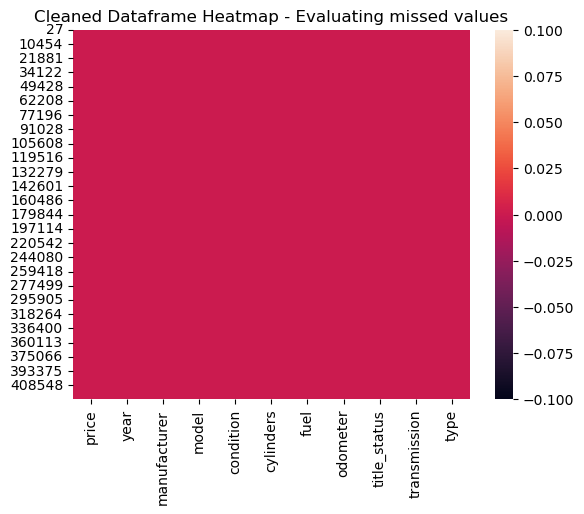

In [345]:
# Re-evaluating missed values using a heatmap
ax = sns.heatmap(
	clean_data.isna()
)
ax.set_title("Cleaned Dataframe Heatmap - Evaluating missed values")
plt.show()

[Text(0.5, 1.0, 'Price Distribution without outliers')]

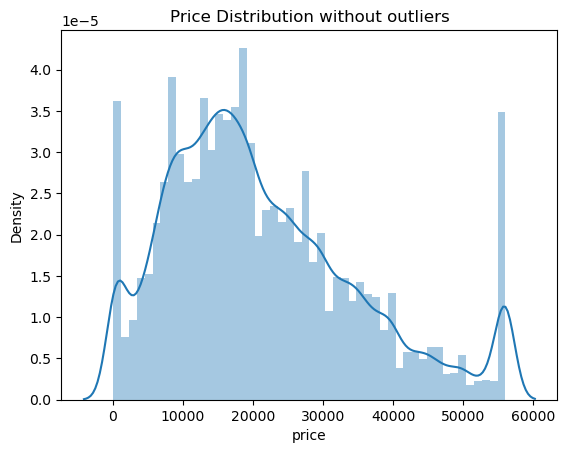

In [346]:
# Visualization of price distributions without outliers
sns.distplot(
    clean_data['price']
).set(title = "Price Distribution without outliers")

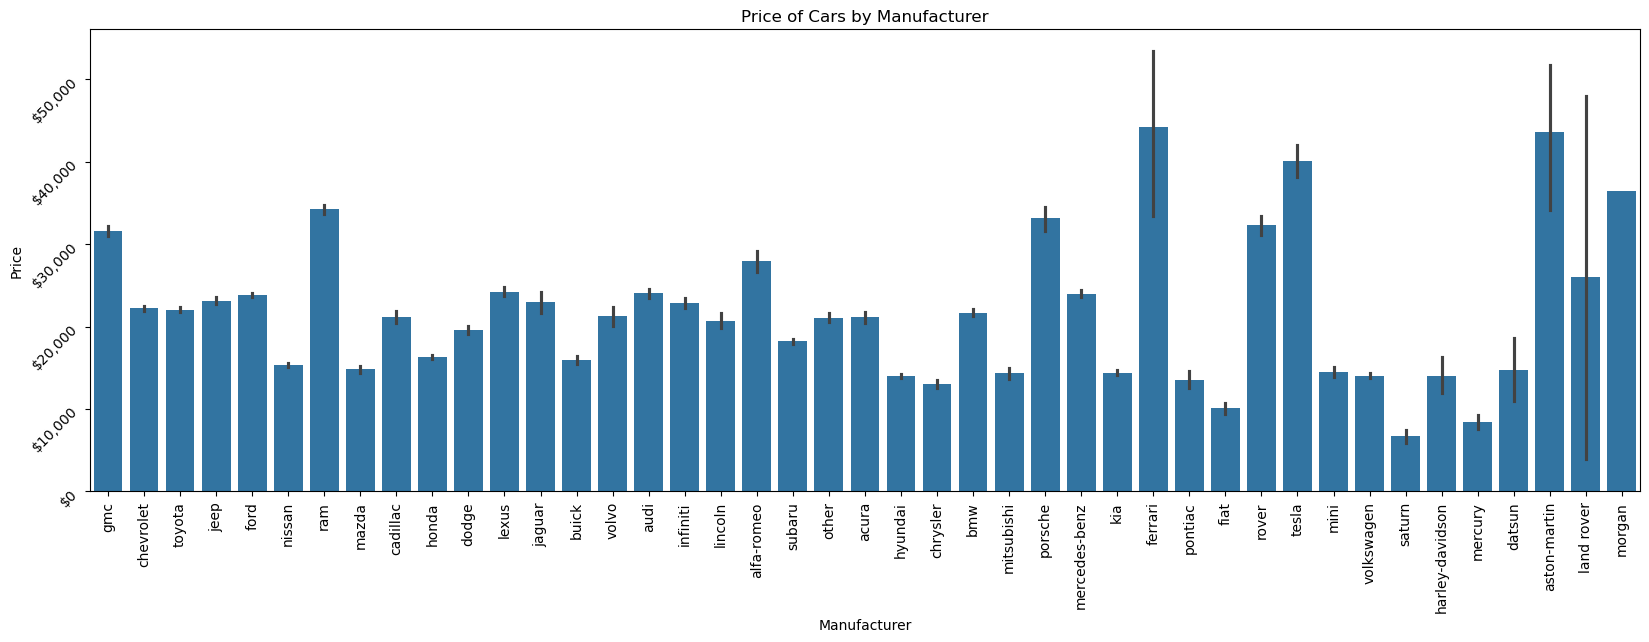

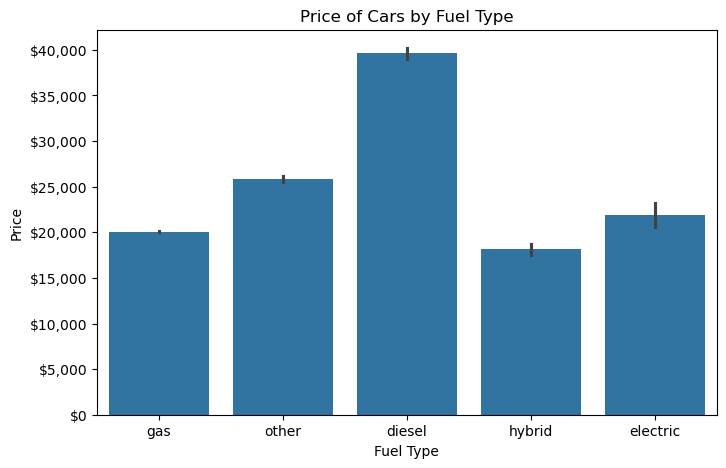

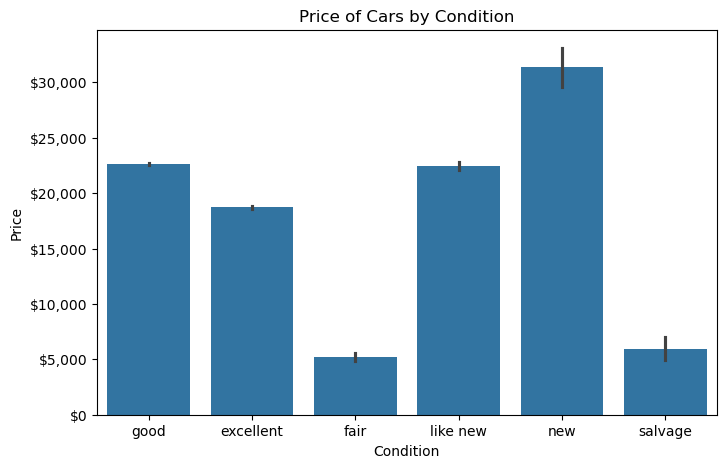

In [347]:
# Review of data relationship to price after data scrubbing
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='manufacturer', y='price', data=clean_data)
plt.yticks(rotation=45)
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='fuel', y='price', data=clean_data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='condition', y='price', data=clean_data)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Condition")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.show()

In [348]:
# Calculate the age of the cars and add it as a column
current_year = 2025  
clean_data['age'] = current_year - clean_data['year']
clean_data.drop('year', axis=1, inplace=True)
clean_data

price   manufacturer                        model  condition  \
27      33590.0            gmc     sierra 1500 crew cab slt       good   
28      22590.0      chevrolet               silverado 1500       good   
29      39590.0      chevrolet          silverado 1500 crew       good   
30      30990.0         toyota         tundra double cab sr       good   
32      27990.0            gmc  sierra 2500 hd extended cab       good   
...         ...            ...                          ...        ...   
426744    800.0       cadillac                      deville  excellent   
426762   7000.0          mazda                rx& gls sport  excellent   
426819  21990.0            bmw       3 series 328i sedan 4d       good   
426833   6800.0         jaguar              xk8 convertible       good   
426873  30990.0  mercedes-benz                glc 300 sport       good   

        cylinders   fuel  odometer title_status transmission         type  age  
27              8    gas   57923.0        clean        other       pickup   11  
28              8    gas   71229.0        clean        other       pickup   15  
29              8    gas   19160.0        clean        other       pickup    5  
30              8    gas   41124.0        clean        other       pickup    8  
32              8    gas   68696.0        clean        other       pickup   13  
...           ...    ...       ...          ...          ...          ...  ...  
426744          8    gas  100000.0        clean    automatic        coupe   25  
426762          6    gas   80000.0        clean    automatic        coupe   43  
426819          6  other   26599.0        clean    automatic        sedan    9  
426833          8    gas   69550.0        clean    automatic  convertible   28  
426873          6    gas   15080.0        clean    automatic        other    7  

[87475 rows x 11 columns]

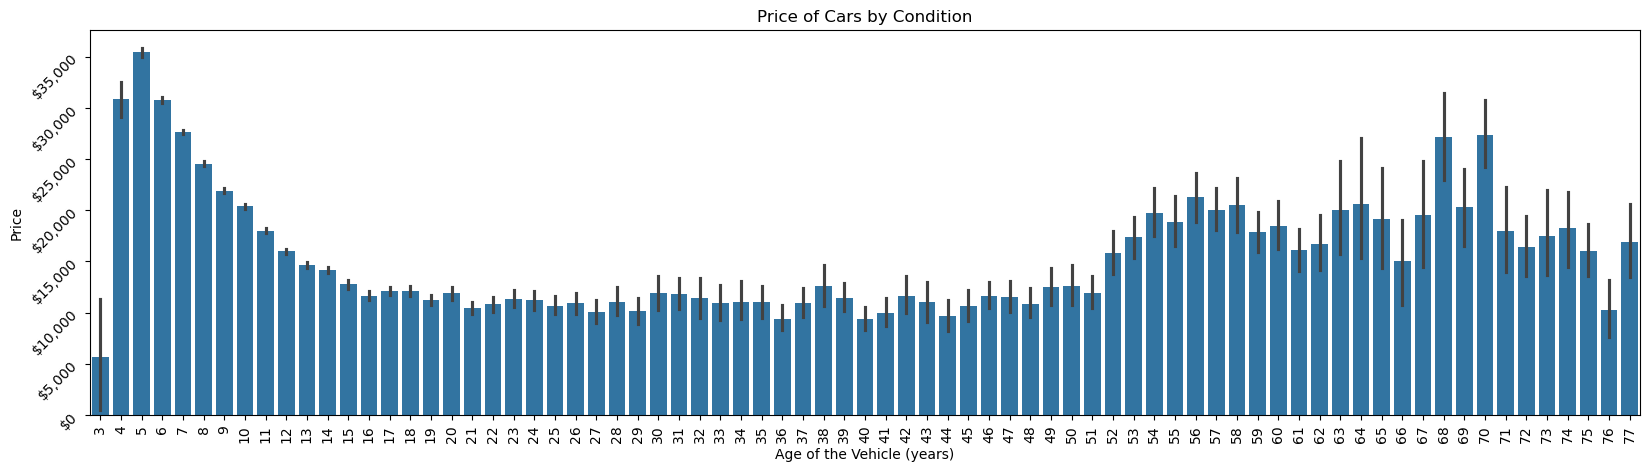

In [349]:
# Display the relationship between car age and price for review
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='age', y='price', data=clean_data)
plt.yticks(rotation=45)
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.title("Price of Cars by Condition")
plt.xlabel("Age of the Vehicle (years)")
plt.ylabel("Price")
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Build Train and Test the model

In [355]:
# HERE WE GO
# Defining a variable to collect results
results = []


# Split dataset into train and test data
X = clean_data.drop('price', axis = 1)
y = clean_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Columns used in regressions excluding objective (price)
features = X.columns

# Categorical columns
category_columns = clean_data.select_dtypes(include='object').columns
category_columns

# Numerical Columns
numeric_columns = X.select_dtypes(include=['int64','float64']).columns
numeric_columns

print("Categorical columns:", category_columns)
print("Numerical columns:", numeric_columns)

Categorical columns: Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object')
Numerical columns: Index(['cylinders', 'odometer', 'age'], dtype='object')


#### Perform Simple Linear Regression

In [356]:
# Encoding columns to apply regression
from category_encoders import TargetEncoder  # Make sure this import is correct
target_encoder = TargetEncoder()
data_encoded = target_encoder.fit_transform(clean_data[features], clean_data["price"])

X1 = data_encoded
y1 = clean_data["price"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Training the model with LinearRegression
first_degree_model = LinearRegression().fit(X1_train, y1_train)

# Executing predictions
# Use X1_train and X1_test directly since they're already encoded
prediction_train = first_degree_model.predict(X1_train)
prediction_test = first_degree_model.predict(X1_test)

# Obtaining errors for training and test datasets
# Use y1_train and y1_test to match the variable names from train_test_split
train_mse = mean_squared_error(y1_train, prediction_train)
test_mse = mean_squared_error(y1_test, prediction_test)

train_r2 = r2_score(y1_train, prediction_train)
test_r2 = r2_score(y1_test, prediction_test)

# Collection results
reg_results = {
    'model': 'Simple Regression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2
}

# Make sure 'results' is defined before this line
if 'results' not in locals():
    results = []
    
results.append(reg_results)

# Print results instead of just the variable name
print(reg_results)

{'model': 'Simple Regression', 'train_mse': 84015329.58909984, 'test_mse': 83967832.81822358, 'train_r2': 0.5496049216053306, 'test_r2': 0.5506220068195817}


#### Polynomial Feature Regression

In [357]:
# Using GridSearchCV, including Target encoder and polynomial features
from category_encoders import TargetEncoder  # Make sure this import is correct

column_transformer = make_column_transformer(
    (TargetEncoder(), category_columns),
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Defining a pipeline doing columns transformations, scaling data and performing LinearRegression
pipe = Pipeline([
    ('transformer', column_transformer), 
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Different degrees to use over the PolynomialFeatures function
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]
}
gscv_linreg = GridSearchCV(
    pipe, 
    param_grid=param_dict
)

# Training the model
gscv_linreg.fit(X_train[features], y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object')),
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x39b917b30>)])),
                                       ('scaler', StandardScaler()),
                                       ('linreg', LinearRegression())]),
             param_grid={'transformer__polynomialfeatures__degree': [1, 2, 3, 4,
                                                                     5]})

In [358]:
# Obtain predictions
pred_train = gscv_linreg.best_estimator_.predict(X_train[features])
pred_test = gscv_linreg.best_estimator_.predict(X_test[features])

# Evaluate the errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

# Reporting results for this regression model
reg_results = {
    'model': 'Polynomial Feature Regression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2
}
results.append(reg_results)
print(reg_results)
print('=======')
print(results)

{'model': 'Polynomial Feature Regression', 'train_mse': 69789879.06241144, 'test_mse': 74475761.8757098, 'train_r2': 0.6258656818320996, 'test_r2': 0.601421552885123}
[{'model': 'Simple Regression', 'train_mse': 84015329.58909984, 'test_mse': 83967832.81822358, 'train_r2': 0.5496049216053306, 'test_r2': 0.5506220068195817}, {'model': 'Polynomial Feature Regression', 'train_mse': 69789879.06241144, 'test_mse': 74475761.8757098, 'train_r2': 0.6258656818320996, 'test_r2': 0.601421552885123}]


#### Polynomial Ridge Regression

In [359]:
## Making transformations (TargetEncoder) and including polynomial features
column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),                                 
    (TargetEncoder(), category_columns),
)

# Pipeline to transform, scale and to execute a ridge regression
pipe = Pipeline([
    ('transformer', column_transformer), 
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Possible values to evaluate over the polynomial features. In this case, iterating with polynomial features and alpha
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(0, 5, 10)
}
gscv_ridge = GridSearchCV(
    pipe, 
    param_grid=param_dict
)

# Training the model
gscv_ridge.fit(X_train[features], y_train)



GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x34591fd10>),
                                                                        ('targetencoder',
                                                                         TargetEncoder(),
                                                                         Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object'))])),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]),
                         'transformer__polynomialfeatures__degree': [1, 2, 3, 4,
                                                                     5]})

In [360]:
# Obtain predictions
pred_train = gscv_ridge.best_estimator_.predict(X_train[features])
pred_test = gscv_ridge.best_estimator_.predict(X_test[features])

# Evaluate error
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

# Report results
reg_results = {
    'model': 'Polynomial Feature Ridge Regression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'hyperParams': gscv_ridge.best_params_
}
results.append(reg_results)

In [361]:
results

[{'model': 'Simple Regression',
  'train_mse': 84015329.58909984,
  'test_mse': 83967832.81822358,
  'train_r2': 0.5496049216053306,
  'test_r2': 0.5506220068195817},
 {'model': 'Polynomial Feature Regression',
  'train_mse': 69789879.06241144,
  'test_mse': 74475761.8757098,
  'train_r2': 0.6258656818320996,
  'test_r2': 0.601421552885123},
 {'model': 'Polynomial Feature Ridge Regression',
  'train_mse': 70142952.99946544,
  'test_mse': 74920625.5481652,
  'train_r2': 0.6239728991180843,
  'test_r2': 0.599040737069623,
  'hyperParams': {'ridge__alpha': np.float64(1.0),
   'transformer__polynomialfeatures__degree': 5}}]

#### Lasso Regression with polynomial features


In [362]:
from category_encoders import TargetEncoder  # Make sure this import is correct

## Using transformations cover categorical columns
column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),                                 
    (TargetEncoder(), category_columns),
)

# Using a pipelne to perform a lasso regression over scaled and transformed data
pipe = Pipeline([
    ('transformer', column_transformer), 
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state = 42))
])

# Parameters used over the polynomial features
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]
}
gscv_lasso = GridSearchCV(
    pipe, 
    param_grid=param_dict
)

# Training the model
gscv_lasso.fit(X_train[features], y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x33b661850>),
                                                                        ('targetencoder',
                                                                         TargetEncoder(),
                                                                         Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object'))])),
                                       ('scaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=42))]),
             param_grid={'transformer__polynomialfeatures__degree': [1, 2, 3, 4,
                                                                     5]})

In [363]:
# Obtain predictions
pred_train = gscv_lasso.best_estimator_.predict(X_train[features])
pred_test = gscv_lasso.best_estimator_.predict(X_test[features])

# Get errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

# Report results
reg_results = {
    'model': 'Lasso Regression with Polynomial Features',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'hyperParams': gscv_lasso.best_params_
}
results.append(reg_results)

In [364]:
results

[{'model': 'Simple Regression',
  'train_mse': 84015329.58909984,
  'test_mse': 83967832.81822358,
  'train_r2': 0.5496049216053306,
  'test_r2': 0.5506220068195817},
 {'model': 'Polynomial Feature Regression',
  'train_mse': 69789879.06241144,
  'test_mse': 74475761.8757098,
  'train_r2': 0.6258656818320996,
  'test_r2': 0.601421552885123},
 {'model': 'Polynomial Feature Ridge Regression',
  'train_mse': 70142952.99946544,
  'test_mse': 74920625.5481652,
  'train_r2': 0.6239728991180843,
  'test_r2': 0.599040737069623,
  'hyperParams': {'ridge__alpha': np.float64(1.0),
   'transformer__polynomialfeatures__degree': 5}},
 {'model': 'Lasso Regression with Polynomial Features',
  'train_mse': 70838716.70675343,
  'test_mse': 75733766.7577818,
  'train_r2': 0.6202430018359959,
  'test_r2': 0.5946889781556964,
  'hyperParams': {'transformer__polynomialfeatures__degree': 5}}]

#### Linear Regression with Sequential Feature Selector


In [365]:
from category_encoders import TargetEncoder  # Make sure this import is correct
# Exeucting transformation, preparing data
column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),                                 
    (TargetEncoder(), category_columns),
)

# Pipeline to apply a Linear regression and SequentialFeatureSelector once data has been transformed
pipe = Pipeline([
    ('transformer', column_transformer), 
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('model', LinearRegression())
])

# Params to iterate over the selector
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
gscv_sf = GridSearchCV(pipe, param_grid=param_dict)

# Train the model
gscv_sf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x3410ec1d0>),
                                                                        ('targetencoder',
                                                                         TargetEncoder(),
                                                                         Index(['manufacturer', 'model', 'condition', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object'))])),
                                       ('selector',
                                        SequentialFeatureSelector(estimator=LinearRegression())),
                                       ('model', LinearRegression())]),
             param_grid={'selector__n_features_to_select': [2, 3, 4, 5]})

In [366]:
# Obtain predictions
pred_train = gscv_sf.best_estimator_.predict(X_train[features])
pred_test = gscv_sf.best_estimator_.predict(X_test[features])

# Calculate errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

# Report results
reg_results = {
    'model': 'Linear Regression with Sequential Feature Selection',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'hyperParams': gscv_sf.best_params_
}
results.append(reg_results)

In [367]:
results_dataframe = pd.DataFrame(results)
results_dataframe

model     train_mse  \
0                                    Simple Regression  8.401533e+07   
1                        Polynomial Feature Regression  6.978988e+07   
2                  Polynomial Feature Ridge Regression  7.014295e+07   
3            Lasso Regression with Polynomial Features  7.083872e+07   
4  Linear Regression with Sequential Feature Selection  8.075360e+07   

       test_mse  train_r2   test_r2  \
0  8.396783e+07  0.549605  0.550622   
1  7.447576e+07  0.625866  0.601422   
2  7.492063e+07  0.623973  0.599041   
3  7.573377e+07  0.620243  0.594689   
4  8.852256e+07  0.567091  0.526246   

                                                           hyperParams  
0                                                                  NaN  
1                                                                  NaN  
2  {'ridge__alpha': 1.0, 'transformer__polynomialfeatures__degree': 5}  
3                       {'transformer__polynomialfeatures__degree': 5}  
4                                {'selector__n_features_to_select': 5}

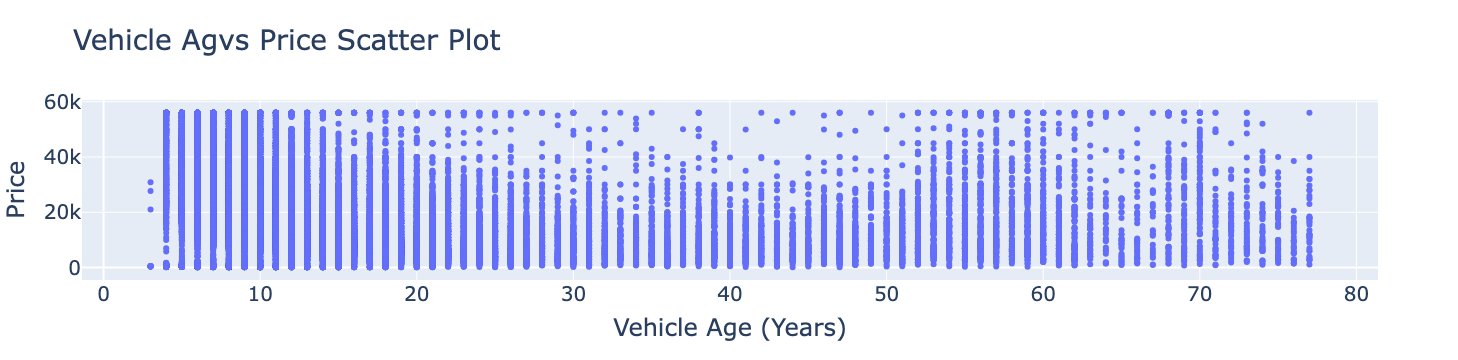

In [368]:
data_pred = clean_data.copy() 
features = data_pred.drop(['price'], axis=1)
price = data_pred['price']

data_pred['prediction'] = gscv_linreg.best_estimator_.predict(features)

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=features['age'], 
        y=data_pred['price'],
        mode='markers',
        name='actual'
    )
)


fig.update_layout(
    font_size=20,
    title='Vehicle Agvs Price Scatter Plot',
    xaxis_title='Vehicle Age (Years)',
    yaxis_title='Price'
)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Let's Compare the results of our models

Text(0.5, 1.0, 'Model Comparisson')

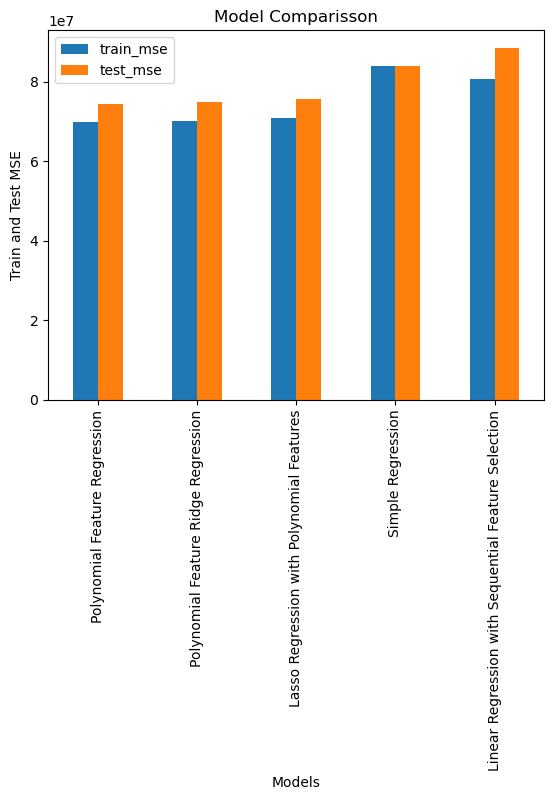

In [369]:
results_dataframe[['model', 'train_mse', 'test_mse']].sort_values('test_mse', ascending=True).plot(x='model', kind='bar', stacked=False)

plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Train and Test MSE")
plt.title('Model Comparisson')



Text(0.5, 1.0, 'Model Comparisson')

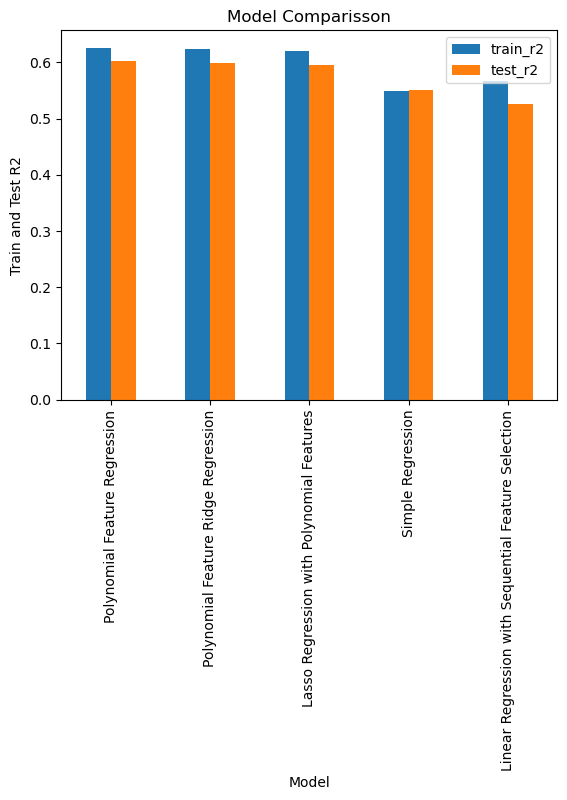

In [370]:
results_df = pd.DataFrame(results)
results_df[['model', 'train_r2', 'test_r2']].sort_values('test_r2', ascending=False).plot(x='model', kind='bar', stacked=False)

plt.xlabel("Model")
plt.ylabel("Train and Test R2")
plt.title('Model Comparisson')


In [371]:
# Evaluating the Strength of each feature.
scoring = [ 'neg_mean_squared_error']


r_multi = permutation_importance(
            gscv_linreg.best_estimator_, 
            X_test, 
            y_test, 
            n_repeats=30, 
            random_state=21, 
            scoring=scoring
        )

# Generate sorted data frame by order of feature strength
importances_tr = dict(
        zip(
                X_train.columns, 
                r_multi['neg_mean_squared_error'].importances_mean
        )
)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
strength_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Strength'])
display(strength_df)

Strength
age           5.372792e+07
model         4.245140e+07
cylinders     1.363902e+07
odometer      1.290991e+07
fuel          6.559016e+06
manufacturer  3.234746e+06
title_status  1.754596e+06
type          1.282122e+06
transmission  9.590923e+05
condition     4.310212e+05

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'age'),
  Text(1, 0, 'model'),
  Text(2, 0, 'cylinders'),
  Text(3, 0, 'odometer'),
  Text(4, 0, 'fuel'),
  Text(5, 0, 'manufacturer'),
  Text(6, 0, 'title_status'),
  Text(7, 0, 'type'),
  Text(8, 0, 'transmission'),
  Text(9, 0, 'condition')])

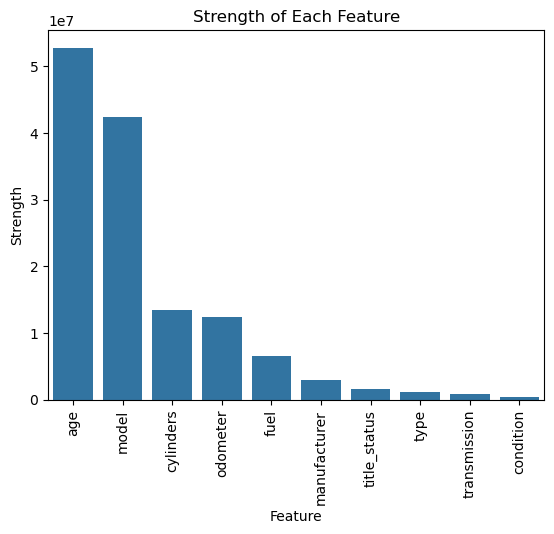

In [335]:
# Visualize each feature's strength
strength_df = strength_df.reset_index()

sns.barplot(data = strength_df, x="index", y="Strength")

plt.xlabel("Feature")
plt.ylabel("Strength")
plt.title('Strength of Each Feature')
plt.xticks(rotation=90)

[Text(0.5, 1.0, 'Strongest Feature Correlation Heatmap')]

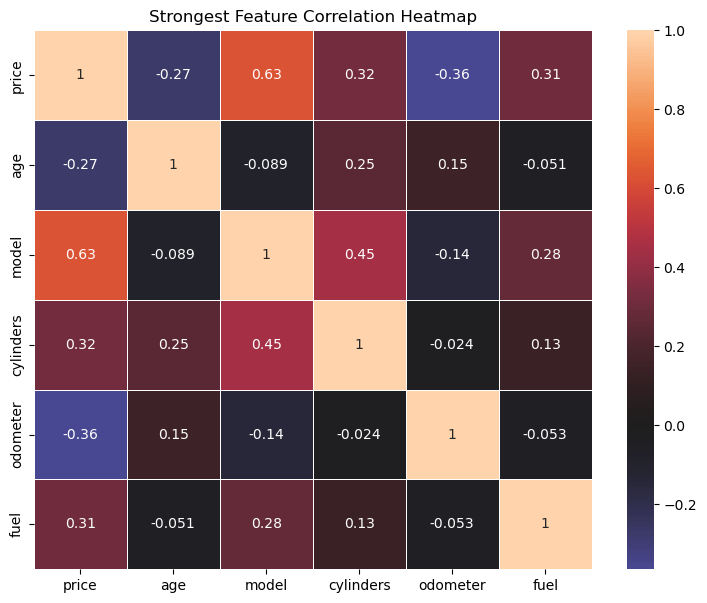

In [372]:
# Correlation of top 5 identified features
features_strength = ["price", "age", "model", "cylinders", "odometer" , "fuel"]
target_encoder = TargetEncoder()
df_target_encoded = target_encoder.fit_transform(clean_data[features_strength], clean_data["price"])

f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(df_target_encoded.corr(), 
    center = 0, 
    linewidth = .7, 
    annot = True
).set(title='Strongest Feature Correlation Heatmap')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

##### Let's Visualize how the different Features identified affect price

In [373]:
visualization_df = clean_data.copy()

visualization_df.sample(10)

price manufacturer                  model  condition  cylinders  \
376132   6500.0         ford       f-250 super duty       good          8   
183573  20900.0      pontiac             superchief  excellent          8   
337270  21995.0    chevrolet      silverado 1500 lt       good          8   
334847   5466.0       toyota             corolla le       good          6   
300131   5295.0        dodge            caliber r/t       good          6   
151720  16800.0   mitsubishi              outlander  excellent          4   
311219  15995.0         ford                  f-150  excellent          8   
139583  34990.0         jeep  wrangler sport suv 2d       good          6   
382328  22995.0      lincoln                    mkz  excellent          4   
391094  24500.0         ford               explorer       good          4   

          fuel  odometer title_status transmission    type  age  
376132  diesel  100000.0        clean    automatic  pickup   21  
183573     gas    5168.0        clean    automatic   other   68  
337270   other   84978.0        clean    automatic  pickup   12  
334847     gas   95098.0        clean    automatic   sedan   20  
300131     gas  100000.0        clean       manual   sedan   16  
151720     gas   58100.0        clean    automatic     SUV    9  
311219     gas   76952.0        clean    automatic  pickup   20  
139583   other   34588.0        clean        other   other    6  
382328  hybrid   23792.0        clean    automatic   sedan    8  
391094     gas   76803.0        clean    automatic     SUV    8

In [374]:
# Categorize the data and display visualizations, using age and odometer value
# - age    --> age_category: Using the descriptive categories below
# - odomter --> odomter_category: Classifying by using odometer ranges

# Vintage : >35 years old. 
# Classic : >20 years old
# Modern  : >3 years old
# New Model : 3 years old or newer
print(min(clean_data['age']))

# Fix: Reorder the bins to be monotonically increasing
# Age is typically measured in years from the present, so smaller numbers are newer cars

age_bins = [0, 3, 20, 35, 45, 100]
age_categories = ['Like New', 'Modern', 'Classic', 'Vintage', 'Collectible Antique']

visualization_df['age_category'] = pd.cut(
        visualization_df['age'], 
        age_bins,  
        labels = age_categories,  
        include_lowest = True
) 

# Odometer categories
max_odometer = max(visualization_df['odometer'])
odometer_bins = [0, 15000, 40000, 70000, max_odometer]
odometer_categories = ['Zero', 'Low Miles', 'Medium Miles', 'High Miles']

visualization_df['odometer_category'] = pd.cut(
        visualization_df['odometer'], 
        odometer_bins,  
        labels = odometer_categories,  
        include_lowest = True
) 

display(visualization_df.sample(10))
display(age_bins)
display(odometer_bins)

3


price   manufacturer                        model  condition  \
142110  18500.0  mercedes-benz                          gla  excellent   
337290  36487.0          dodge              durango citadel       good   
401881  36999.0           jeep   grand cherokee limited 4x4       good   
96147   14950.0           jeep                     wrangler  excellent   
156863  21995.0         toyota                       tacoma       good   
129605  21995.0           audi              a6 3.0t quattro  excellent   
341499  35990.0            gmc  acadia denali sport utility       good   
27482   19865.0          other                         Edge       good   
74460   18089.0        hyundai                       tucson       good   
58786   27890.0         toyota                         rav4  excellent   

        cylinders   fuel  odometer title_status transmission   type  age  \
142110          6    gas   58830.0        clean    automatic    SUV   10   
337290          6  other   31503.0        clean    automatic    SUV    7   
401881          6    gas   18631.0        clean    automatic    SUV    6   
96147           6    gas    2000.0        clean    automatic    SUV   36   
156863          6    gas   88015.0      rebuilt    automatic  truck   14   
129605          6    gas   20431.0        clean    automatic  sedan   12   
341499          6    gas   31739.0        clean        other    SUV    7   
27482           4    gas   81140.0        clean    automatic    SUV    7   
74460           4    gas   37738.0        clean    automatic    SUV    9   
58786           6    gas   23841.0        clean    automatic    SUV    7   

       age_category odometer_category  
142110       Modern      Medium Miles  
337290       Modern         Low Miles  
401881       Modern         Low Miles  
96147       Vintage              Zero  
156863       Modern        High Miles  
129605       Modern         Low Miles  
341499       Modern         Low Miles  
27482        Modern        High Miles  
74460        Modern         Low Miles  
58786        Modern         Low Miles

[0, 3, 20, 35, 45, 100]

[0, 15000, 40000, 70000, 100000.0]

#### Total Sales of the Top Ten Models sold by age of the vehicle.

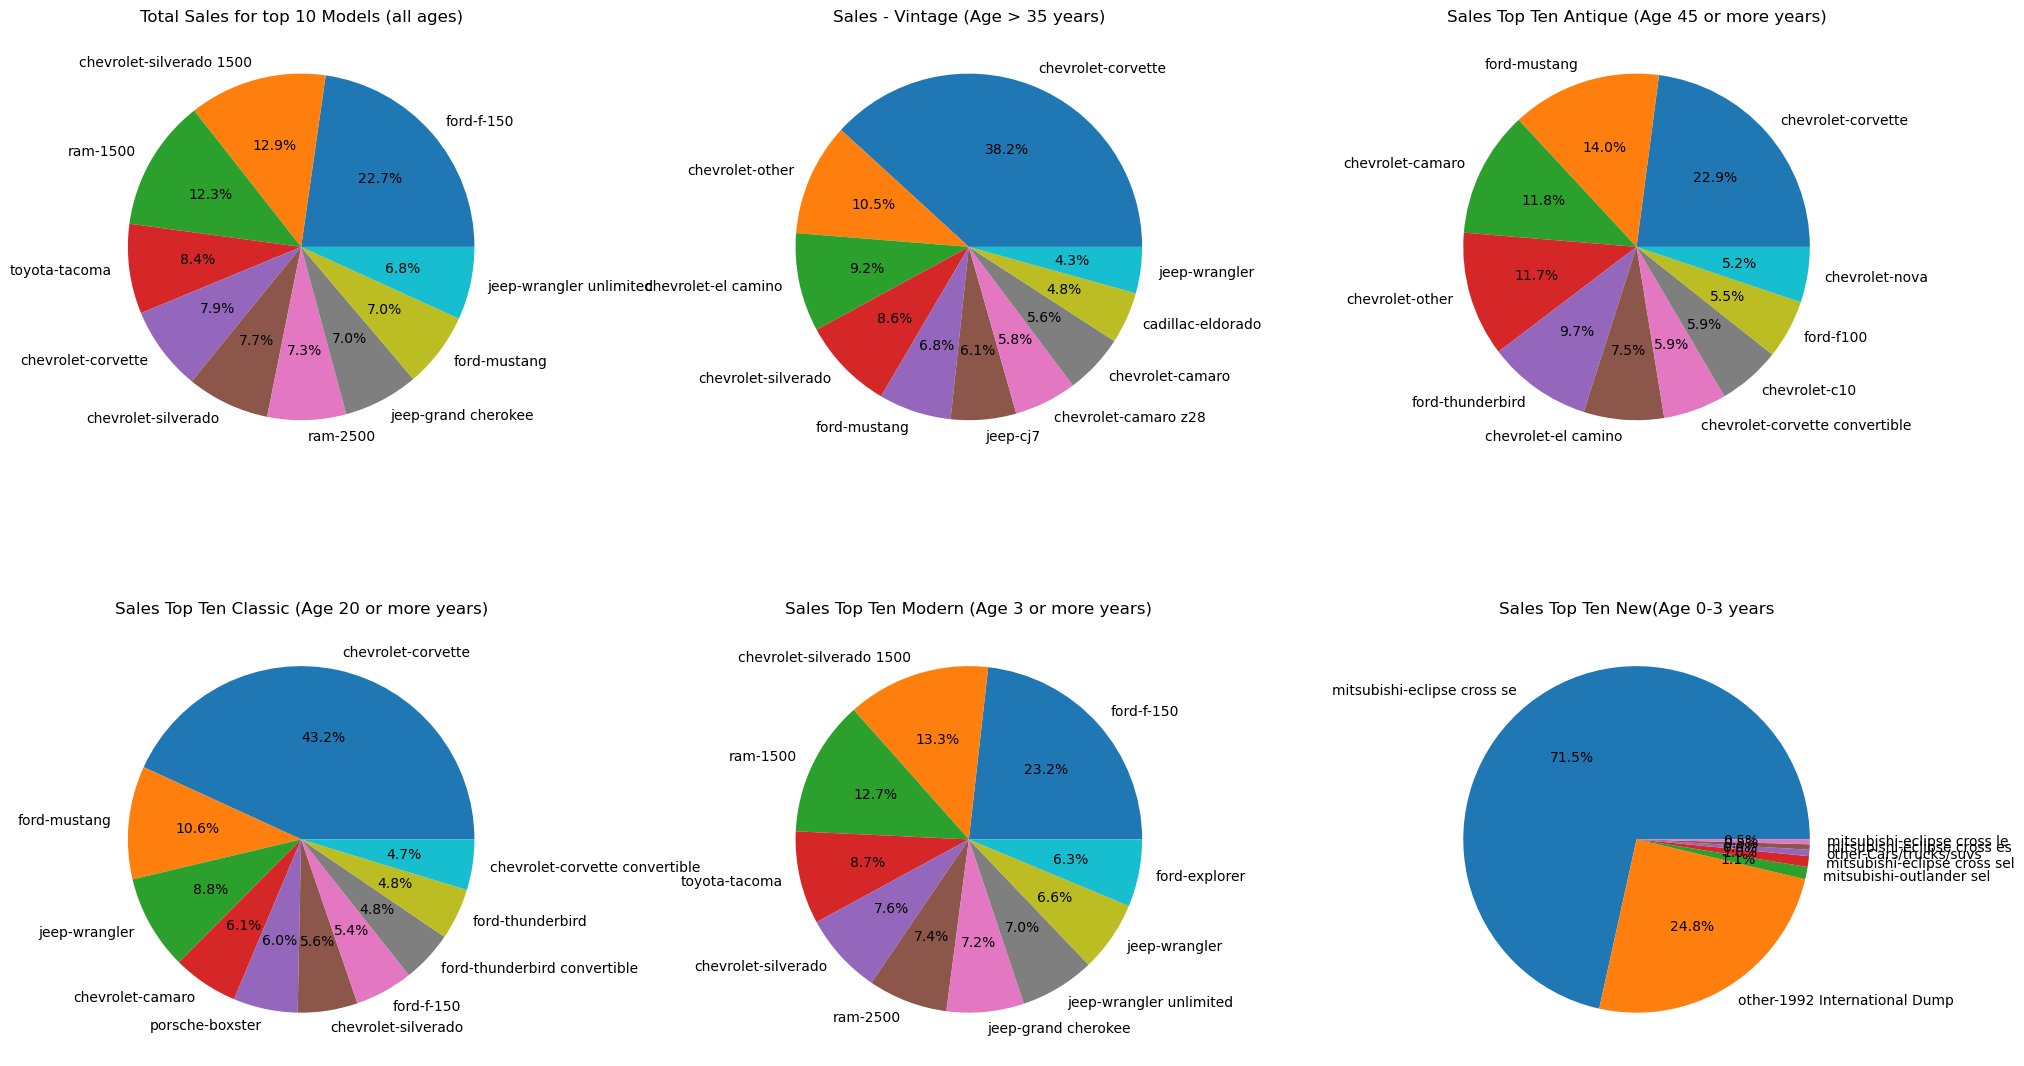

In [375]:
fig, ax = plt.subplots(2, 3, figsize = (20, 12)) 


ax[0][0].set_title('Total Sales for top 10 Models (all ages)')
ax[0][0].pie(
    df_sales_by_model['price'], 
    labels=df_sales_by_model['manufacturer'] + '-' + df_sales_by_model['model'], 
    autopct='%1.1f%%'
)

# Antique pie chart
df_sales_by_q3 = visualization_df.query('age_category == "Collectible Antique"').groupby(['manufacturer', 'model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
ax[0][2].set_title('Sales Top Ten Antique (Age 45 or more years)')
ax[0][2].pie(
    df_sales_by_q3['price'], 
    labels=df_sales_by_q3['manufacturer'] + '-' + df_sales_by_q3['model'],  # Changed to use df_sales_by_q3
    autopct='%1.1f%%'
)

# Vintage pie chart
df_sales_by_q4 = visualization_df.query('age_category == "Vintage"').groupby(['manufacturer', 'model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
ax[0][1].set_title('Sales - Vintage (Age > 35 years)')
ax[0][1].pie(
    df_sales_by_q4['price'], 
    labels=df_sales_by_q4['manufacturer'] + '-' + df_sales_by_q4['model'],  # Changed to use df_sales_by_q4
    autopct='%1.1f%%'
)

# Classic pie chart
df_sales_by_q2 = visualization_df.query('age_category == "Classic"').groupby(['manufacturer', 'model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
ax[1][0].set_title('Sales Top Ten Classic (Age 20 or more years)')
ax[1][0].pie(
    df_sales_by_q2['price'], 
    labels=df_sales_by_q2['manufacturer'] + '-' + df_sales_by_q2['model'],  # Changed to use df_sales_by_q2
    autopct='%1.1f%%'
)

# Modern pie chart
df_sales_by_modern = visualization_df.query('age_category == "Modern"').groupby(['manufacturer', 'model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
ax[1][1].set_title('Sales Top Ten Modern (Age 3 or more years)')
ax[1][1].pie(
    df_sales_by_modern['price'], 
    labels=df_sales_by_modern['manufacturer'] + '-' + df_sales_by_modern['model'],  # Changed variable name and labels
    autopct='%1.1f%%'
)

# New Model pie chart
df_sales_by_new = visualization_df.query('age_category == "Like New"').groupby(['manufacturer', 'model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
ax[1][2].set_title('Sales Top Ten New(Age 0-3 years')
ax[1][2].pie(
    df_sales_by_new['price'], 
    labels=df_sales_by_new['manufacturer'] + '-' + df_sales_by_new['model'],  # Changed variable name and labels
    autopct='%1.1f%%'
)

plt.tight_layout()

#### Top 10 Models sold from New and Modern categories with Odometer reading distribution

man_model odometer_category       price
0        chevrolet-silverado              Zero   1897687.0
1        chevrolet-silverado         Low Miles   3335940.5
2        chevrolet-silverado      Medium Miles   3973220.5
3        chevrolet-silverado        High Miles   4908157.0
4   chevrolet-silverado 1500              Zero   3170050.0
5   chevrolet-silverado 1500         Low Miles   6927894.0
6   chevrolet-silverado 1500      Medium Miles   6273518.5
7   chevrolet-silverado 1500        High Miles   8491956.5
8              ford-explorer              Zero   1440829.5
9              ford-explorer         Low Miles   2908451.0
10             ford-explorer      Medium Miles   3446845.0
11             ford-explorer        High Miles   3899520.0
12                ford-f-150              Zero   5328431.5
13                ford-f-150         Low Miles  11922737.5
14                ford-f-150      Medium Miles  12099902.0
15                ford-f-150        High Miles  13903693.0
16       jeep-grand cherokee              Zero   1249698.0
17       jeep-grand cherokee         Low Miles   4989097.5
18       jeep-grand cherokee      Medium Miles   3856107.5
19       jeep-grand cherokee        High Miles   3361370.0
20             jeep-wrangler              Zero   1365191.5
21             jeep-wrangler         Low Miles   2774179.0
22             jeep-wrangler      Medium Miles   3318814.0
23             jeep-wrangler        High Miles   4820253.0
24   jeep-wrangler unlimited              Zero   1288317.0
25   jeep-wrangler unlimited         Low Miles   4271797.5
26   jeep-wrangler unlimited      Medium Miles   4091144.0
27   jeep-wrangler unlimited        High Miles   3366035.0
28                  ram-1500              Zero   2824242.0
29                  ram-1500         Low Miles   6609640.0
30                  ram-1500      Medium Miles   7379322.0
31                  ram-1500        High Miles   6846990.5
32                  ram-2500              Zero   1550772.5
33                  ram-2500         Low Miles   3621576.0
34                  ram-2500      Medium Miles   4885655.5
35                  ram-2500        High Miles   3778452.5
36             toyota-tacoma              Zero   1904129.0
37             toyota-tacoma         Low Miles   5665719.0
38             toyota-tacoma      Medium Miles   4463567.5
39             toyota-tacoma        High Miles   4116824.0

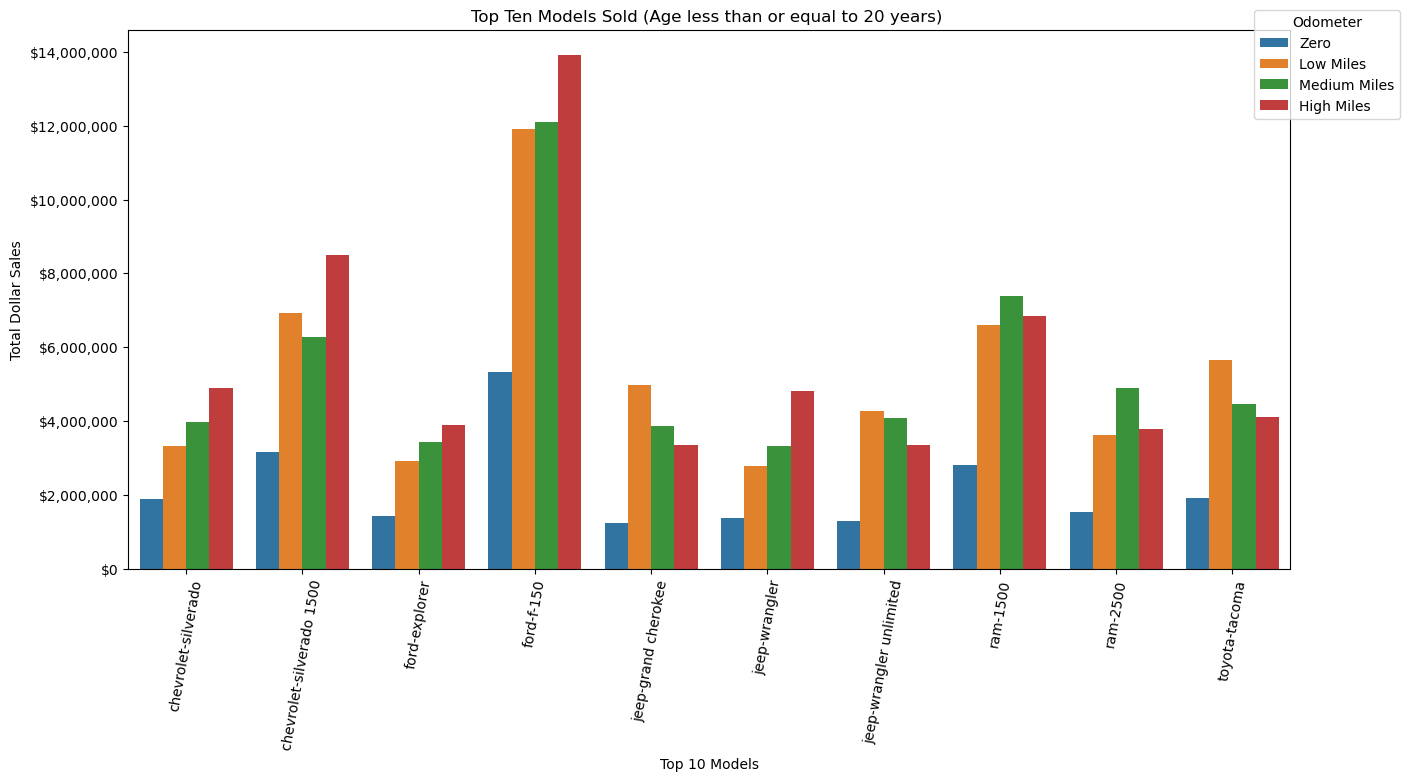

In [378]:
df_new = visualization_df.copy()
df_new = df_new.query('age <= 20')
df_new['man_model'] = df_new['manufacturer'] + '-' + df_new['model']

df_topmodels = df_new.groupby(['man_model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
top_models = df_topmodels['man_model'].unique()
df_data = df_new.query('man_model in(@top_models)').groupby(['man_model', 'odometer_category'])['price'].sum().reset_index()

display(df_data)

plt.figure(figsize = (15, 7))
sns.barplot(df_data, x = "man_model", y="price", hue = "odometer_category").set(title = "Top Ten Models Sold (Age less than or equal to 20 years) ")
plt.xticks(rotation = 80)
plt.xlabel('Top 10 Models')
plt.ylabel('Total Dollar Sales')
plt.legend(bbox_to_anchor=(1.1, 1.05), title="Odometer")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.show()

man_model  cylinders       price
0        chevrolet-silverado          6   9981867.5
1        chevrolet-silverado          8   4133137.5
2   chevrolet-silverado 1500          4    484683.0
3   chevrolet-silverado 1500          6   7786675.0
4   chevrolet-silverado 1500          8  16592061.0
5              ford-explorer          4   1852784.0
6              ford-explorer          6   9830361.5
7              ford-explorer          8     12500.0
8                 ford-f-150          6  35060248.0
9                 ford-f-150          8   8194516.0
10       jeep-grand cherokee          4     35936.0
11       jeep-grand cherokee          6  12006945.5
12       jeep-grand cherokee          8   1413391.5
13             jeep-wrangler          4    818718.0
14             jeep-wrangler          6  11433719.5
15             jeep-wrangler          8     26000.0
16   jeep-wrangler unlimited          4    766988.0
17   jeep-wrangler unlimited          6  12138310.5
18   jeep-wrangler unlimited          8    111995.0
19                  ram-1500          4     26999.0
20                  ram-1500          6  12713339.0
21                  ram-1500          8  10838956.5
22                  ram-1500         10     80900.0
23                  ram-2500          6  11734270.0
24                  ram-2500          8   2102186.5
25             toyota-tacoma          4   1786771.0
26             toyota-tacoma          6  14363468.5

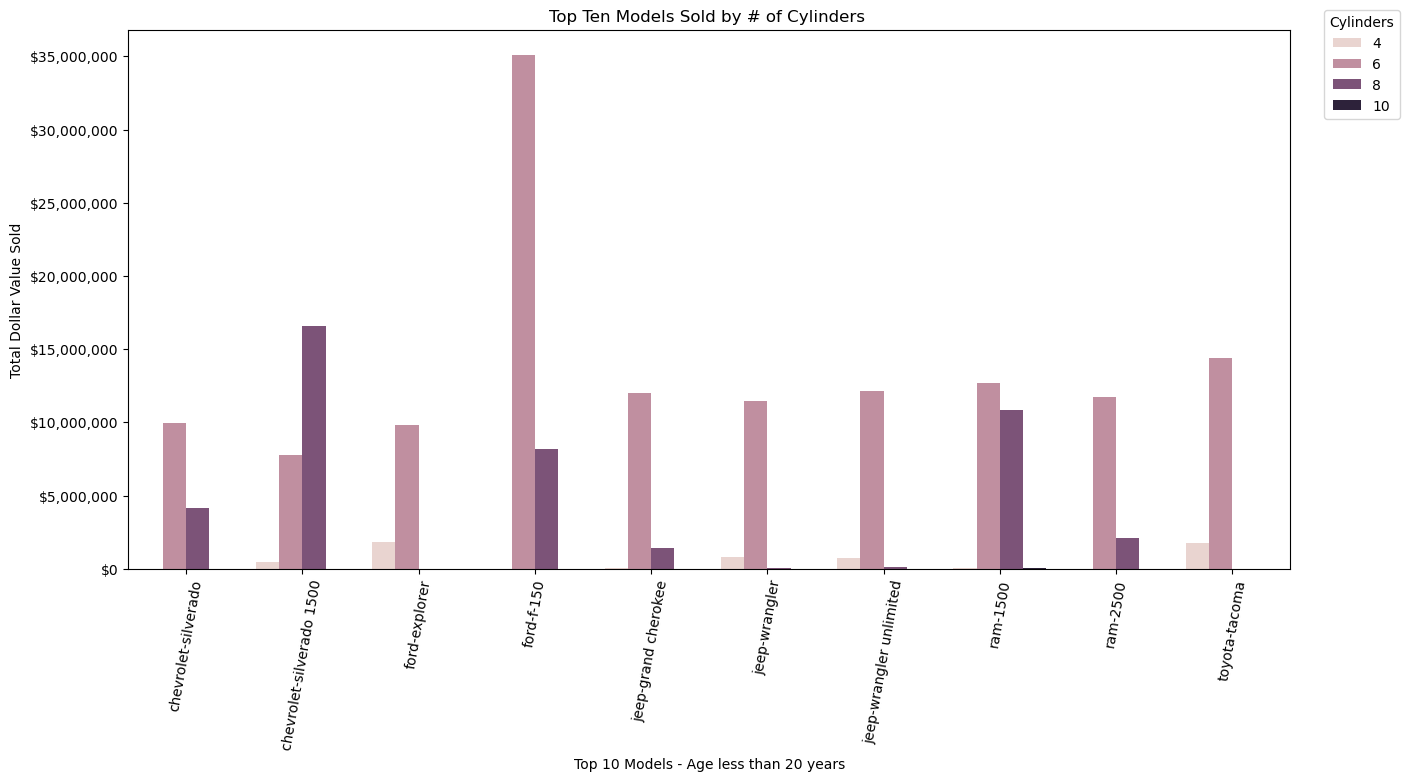

In [379]:
df_new = visualization_df.copy()
df_new = df_new.query('age <= 20')
df_new['man_model'] = df_new['manufacturer'] + '-' + df_new['model']

df_topmodels = df_new.groupby(['man_model'])['price'].agg(sum).reset_index().sort_values('price', ascending=False).iloc[0:10]
top_models = df_topmodels['man_model'].unique()
df_data = df_new.query('man_model in(@top_models)').groupby(['man_model', 'cylinders'])['price'].sum().reset_index()

display(df_data)

plt.figure(figsize = (15, 7))
sns.barplot(df_data, x = "man_model", y="price", hue = "cylinders").set(title = "Top Ten Models Sold by # of Cylinders ")
plt.xticks(rotation = 80)
plt.xlabel('Top 10 Models - Age less than 20 years')
plt.ylabel('Total Dollar Value Sold')
plt.legend(bbox_to_anchor=(1.1, 1.05), title="Cylinders")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.show()